In [ ]:
import os
import cv2

def normalize_coordinates(label_path, image_path):
    # Read the image to get its dimensions
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found: {image_path}")
        return

    height, width, _ = image.shape

    with open(label_path, 'r') as file:
        lines = file.readlines()

    normalized_lines = []
    for line in lines:
        parts = line.strip().split()
        class_id = parts[0]
        center_x = float(parts[1])
        center_y = float(parts[2])
        bbox_width = float(parts[3])
        bbox_height = float(parts[4])

        # Normalize coordinates
        center_x /= width
        center_y /= height
        bbox_width /= width
        bbox_height /= height

        # Ensure coordinates are between 0 and 1
        if 0 <= center_x <= 1 and 0 <= center_y <= 1 and 0 <= bbox_width <= 1 and 0 <= bbox_height <= 1:
            normalized_line = f"{class_id} {center_x} {center_y} {bbox_width} {bbox_height}\n"
            normalized_lines.append(normalized_line)
        else:
            print(f"Skipping corrupt label: {label_path}")

    with open(label_path, 'w') as file:
        file.writelines(normalized_lines)

# Path to the base directory containing train, test, and val folders
base_dir = 'C:/Users/aayud/OneDrive/Desktop/VS Code/Web Dev/TSEC Hacks Artemis/mlserver/wildlife_detection/AOD-20250129T035709Z-002/AOD/data'
sets = ['train', 'val']

for dataset in sets:
    image_dir = os.path.join(base_dir, dataset, 'images')
    label_dir = os.path.join(base_dir, dataset, 'labels')

    # Normalize coordinates in all label files
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        image_path = os.path.join(image_dir, label_file.replace('.txt', '.jpg'))  # Assuming image files are .jpg
        normalize_coordinates(label_path, image_path)

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def load_labels(label_path):
    with open(label_path, 'r') as file:
        lines = file.readlines()
    labels = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        center_x = float(parts[1])
        center_y = float(parts[2])
        bbox_width = float(parts[3])
        bbox_height = float(parts[4])
        labels.append((class_id, center_x, center_y, bbox_width, bbox_height))
    return labels

def draw_bounding_boxes(image, labels):
    height, width, _ = image.shape
    for label in labels:
        class_id, center_x, center_y, bbox_width, bbox_height = label
        x1 = int((center_x - bbox_width / 2) * width)
        y1 = int((center_y - bbox_height / 2) * height)
        x2 = int((center_x + bbox_width / 2) * width)
        y2 = int((center_y + bbox_height / 2) * height)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

def visualize_samples(base_dir, sets, num_samples=5):
    for dataset in sets:
        image_dir = os.path.join(base_dir, dataset, 'images')
        label_dir = os.path.join(base_dir, dataset, 'labels')

        image_files = os.listdir(image_dir)
        label_files = os.listdir(label_dir)

        # Ensure there are corresponding labels and images
        image_files = [f for f in image_files if f.replace('.jpg', '.txt') in label_files]
        label_files = [f for f in label_files if f.replace('.txt', '.jpg') in image_files]

        if len(image_files) == 0 or len(label_files) == 0:
            print(f"No corresponding images and labels found in {dataset} set.")
            continue

        sample_files = random.sample(image_files, min(num_samples, len(image_files)))

        for image_file in sample_files:
            image_path = os.path.join(image_dir, image_file)
            label_path = os.path.join(label_dir, image_file.replace('.jpg', '.txt'))  # Assuming image files are .jpg

            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                continue

            if not os.path.exists(label_path):
                print(f"Label not found: {label_path}")
                continue

            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to read image: {image_path}")
                continue

            labels = load_labels(label_path)
            image_with_boxes = draw_bounding_boxes(image, labels)

            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(f"{dataset} - {image_file}")
            plt.axis('off')
            plt.show()

# Path to the base directory containing train, test, and val folders
base_dir = 'C:/Users/aayud/OneDrive/Desktop/VS Code/Web Dev/TSEC Hacks Artemis/mlserver/wildlife_detection/AOD-20250129T035709Z-002/AOD/data'
sets = ['train', 'val']

# Visualize samples from train and val sets
visualize_samples(base_dir, sets, num_samples=5)

In [6]:
from ultralytics import YOLO

# Initialize the model
model = YOLO('models/yolov8n.pt')

res = model.train(data='./AOD-20250129T035709Z-002/AOD/data/aod.yaml', epochs=1, batch=25, imgsz=640)

In [4]:
import os

def is_label_file_corrupt(label_path):
    try:
        with open(label_path, 'r') as file:
            lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                return True
            class_id = int(parts[0])
            center_x = float(parts[1])
            center_y = float(parts[2])
            bbox_width = float(parts[3])
            bbox_height = float(parts[4])
        return False
    except Exception as e:
        print(f"Error reading label file {label_path}: {e}")
        return True

# Path to the base directory containing train, test, and val folders
base_dir = 'C:/Users/aayud/OneDrive/Desktop/VS Code/Web Dev/TSEC Hacks Artemis/mlserver/wildlife_detection/AOD-20250129T035709Z-002/AOD/data'
sets = ['train', 'val', 'test']

for dataset in sets:
    label_dir = os.path.join(base_dir, dataset, 'labels')

    # Identify and remove corrupt label files
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        if is_label_file_corrupt(label_path):
            print(f"Removing corrupt label file: {label_path}")
            os.remove(label_path)

## New Dataset

In [3]:
# Importing necessary libraries
import os
import shutil
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import copy
from ultralytics import YOLO

In [16]:
# Defining data path and listing its contents
ip_datapath='./data'
os.listdir(ip_datapath)

['buffalo', 'elephant', 'rhino', 'zebra']

In [17]:
image_size=640

In [4]:
# Creating paths for separate images and labels
curr_path=os.getcwd()
# imgtrainpath = os.path.join(curr_path,'images','train')
# imgvalpath=os.path.join(curr_path,'images','validation')
# imgtestpath=os.path.join(curr_path,'images','test')

# labeltrainpath=os.path.join(curr_path,'labels','train')
# labelvalpath=os.path.join(curr_path,'labels','validation')
# labeltestpath=os.path.join(curr_path,'labels','test')

# # Creating directories for all paths defined
# os.makedirs(imgtrainpath)
# os.makedirs(imgvalpath)
# os.makedirs(imgtestpath)
# os.makedirs(labeltrainpath)
# os.makedirs(labelvalpath)
# os.makedirs(labeltestpath)

In [19]:
for dirname in os.listdir(ip_datapath):
    dirpath=os.path.join(ip_datapath, dirname)
    for file in os.listdir(dirpath):
        filepath=os.path.join(dirpath, file)
        newname=dirname+'_'+file
        if file.endswith((".txt")): # if label file, take it to label train path
            shutil.copy(filepath, labeltrainpath)
            path=os.path.join(labeltrainpath, file)
            newpath=os.path.join(labeltrainpath, newname)
        elif file.endswith((".jpg", ".JPG")): # if image file, resize and take it to image train path
            img_resized=cv2.resize(cv2.imread(filepath), (image_size, image_size))
            path=os.path.join(imgtrainpath, file)
            cv2.imwrite(path, img_resized)
            newpath=os.path.join(imgtrainpath, newname)
        os.rename(path, newpath) # Rename the file (label or image)

In [20]:
len(os.listdir(imgtrainpath)), len(os.listdir(labeltrainpath))

(1504, 1504)

In [21]:
# function to check if all elements in the list are actually the same
def are_all_elements_same(lst):
    if not lst:
        return True  # An empty list is considered to have all elements the same.

    first_element = lst[0]
    for element in lst[1:]:
        if element != first_element:
            return False

    return True

In [22]:
for file in os.listdir(labeltrainpath):
    classes_list=[]
    with open(os.path.join(labeltrainpath, file), "r") as f:
        for line in f:
            class_id,_,_,_,_=line.strip().split(" ")
            classes_list.append(class_id) # creating list of all unique animal types in given image
            
    # Checking if different types of animals are present in image
    if not are_all_elements_same(classes_list): 
        filepath=os.path.join(labeltrainpath, file)
        newpath=os.path.join(labeltestpath, file)
        shutil.move(filepath, newpath) # moving label file to test path
        basename=os.path.splitext(file)[0]
        print(basename) # printing the image name
        imgfilename=basename+'.jpg'
        oldimgfilepath=os.path.join(imgtrainpath, imgfilename)
        newimgfilepath=os.path.join(imgtestpath, imgfilename) 
        shutil.move(oldimgfilepath, newimgfilepath) # moving image to test path

buffalo_273
buffalo_291
buffalo_297
buffalo_298
buffalo_299
buffalo_300
buffalo_301
elephant_166
elephant_288
elephant_290
elephant_291
elephant_345
rhino_238
rhino_256
rhino_375
zebra_073
zebra_338
zebra_339


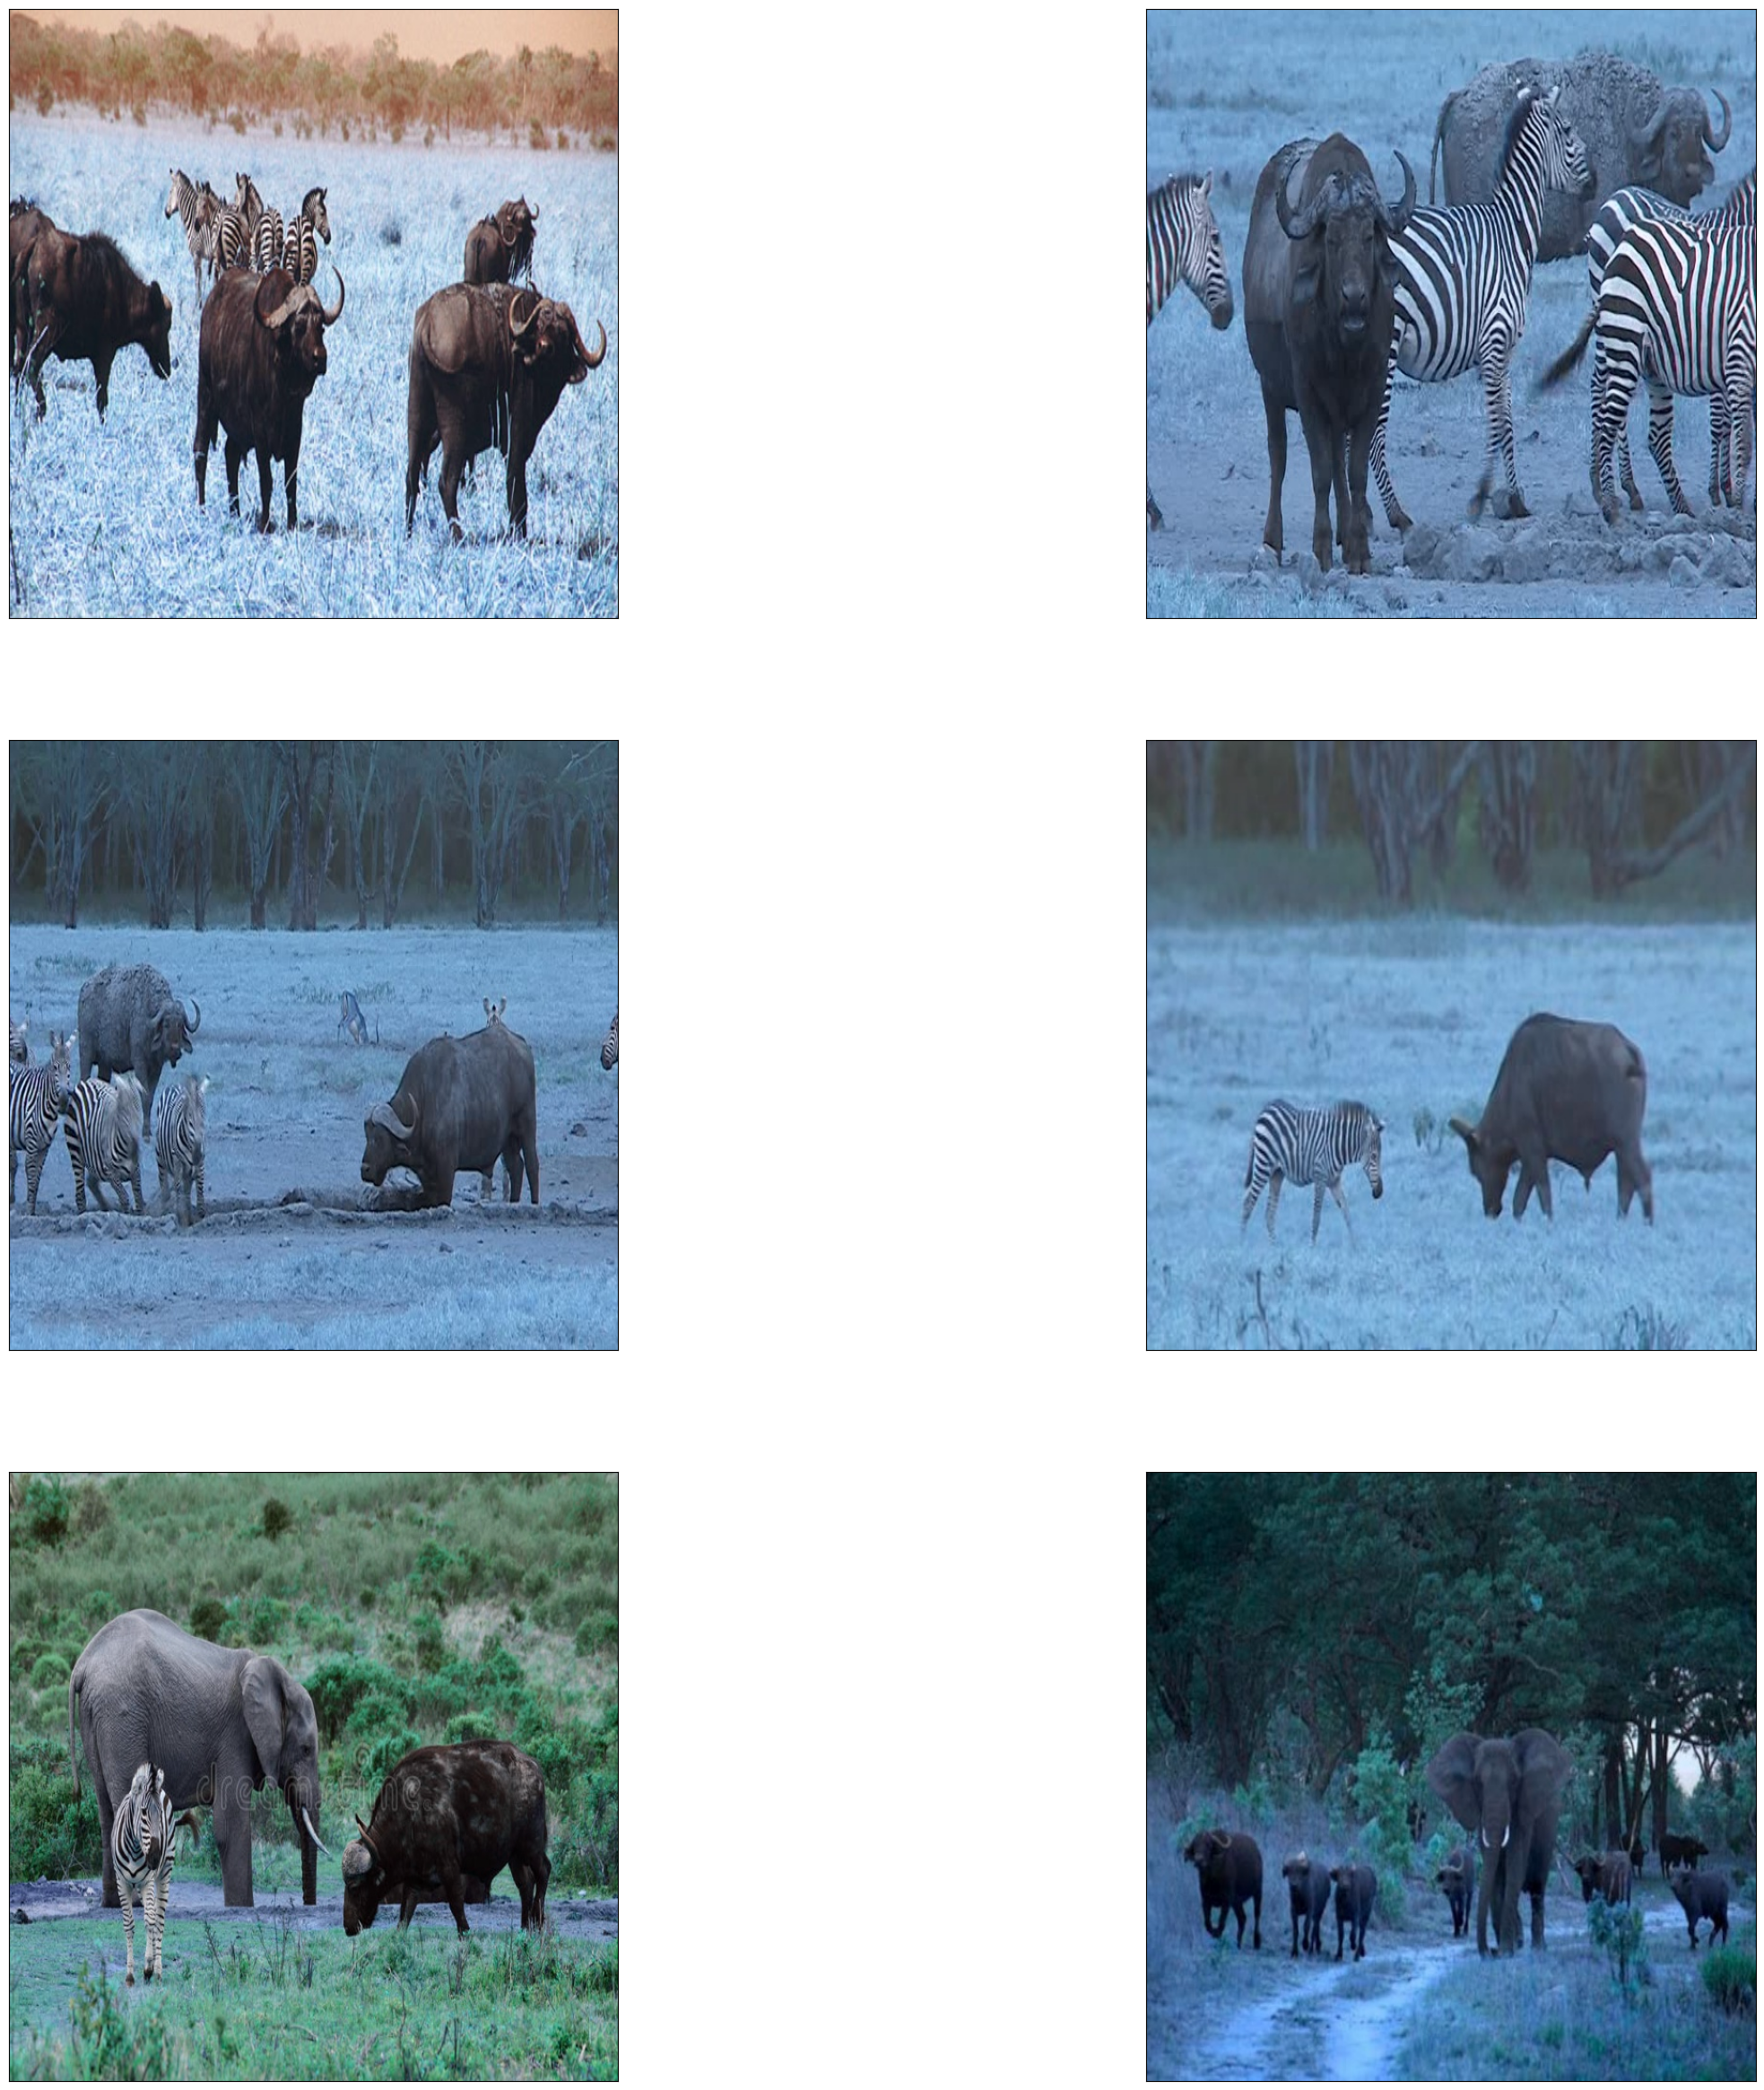

In [23]:
plt.figure(figsize=(30,30))
for i in range(6):
    test_image=os.path.join(imgtestpath, os.listdir(imgtestpath)[i])
    ax=plt.subplot(3,2,i+1)
    
    # Display actual image
    plt.imshow(cv2.imread(test_image)) 
    plt.xticks([])
    plt.yticks([])


In [24]:
# Checking the size of test dataset
len(os.listdir(imgtestpath)), len(os.listdir(labeltestpath))

# Checking the size of training(+validation) dataset
len(os.listdir(imgtrainpath)), len(os.listdir(labeltrainpath))

(1486, 1486)

In [25]:
# moving 20% of data to validation

factor=0.2 

for file in random.sample(os.listdir(imgtrainpath), int(len(os.listdir(imgtrainpath))*factor)):
    basename=os.path.splitext(file)[0]
    textfilename=basename+'.txt'
    labelfilepath=os.path.join(labeltrainpath, textfilename)
    labeldestpath=os.path.join(labelvalpath, textfilename)
    imgfilepath=os.path.join(imgtrainpath, file)
    imgdestpath=os.path.join(imgvalpath, file)
    shutil.move(imgfilepath, imgdestpath)
    shutil.move(labelfilepath, labeldestpath)

In [26]:
len(os.listdir(imgtrainpath)), len(os.listdir(labeltrainpath))
len(os.listdir(imgvalpath)), len(os.listdir(labelvalpath))

(297, 297)

In [27]:
# function to obtain bounding box coordinates from text label files
def get_bbox_from_label(text_file_path):
    bbox_list=[]
    with open(text_file_path, "r") as file:
        for line in file:
            class_id,x_centre,y_centre,width,height=line.strip().split(" ")
            x1=(float(x_centre)+(float(width)/2))*image_size
            x0=(float(x_centre)-(float(width)/2))*image_size
            y1=(float(y_centre)+(float(height)/2))*image_size
            y0=(float(y_centre)-(float(height)/2))*image_size
            
            vertices=np.array([[int(x0), int(y0)], [int(x1), int(y0)], 
                               [int(x1),int(y1)], [int(x0),int(y1)]])
            bbox_list.append(vertices)      
    return tuple(bbox_list)

In [28]:
# defining red color in RGB to draw bounding box
red=(255,0,0) 
# defining newline variable for config file
newline='\n'

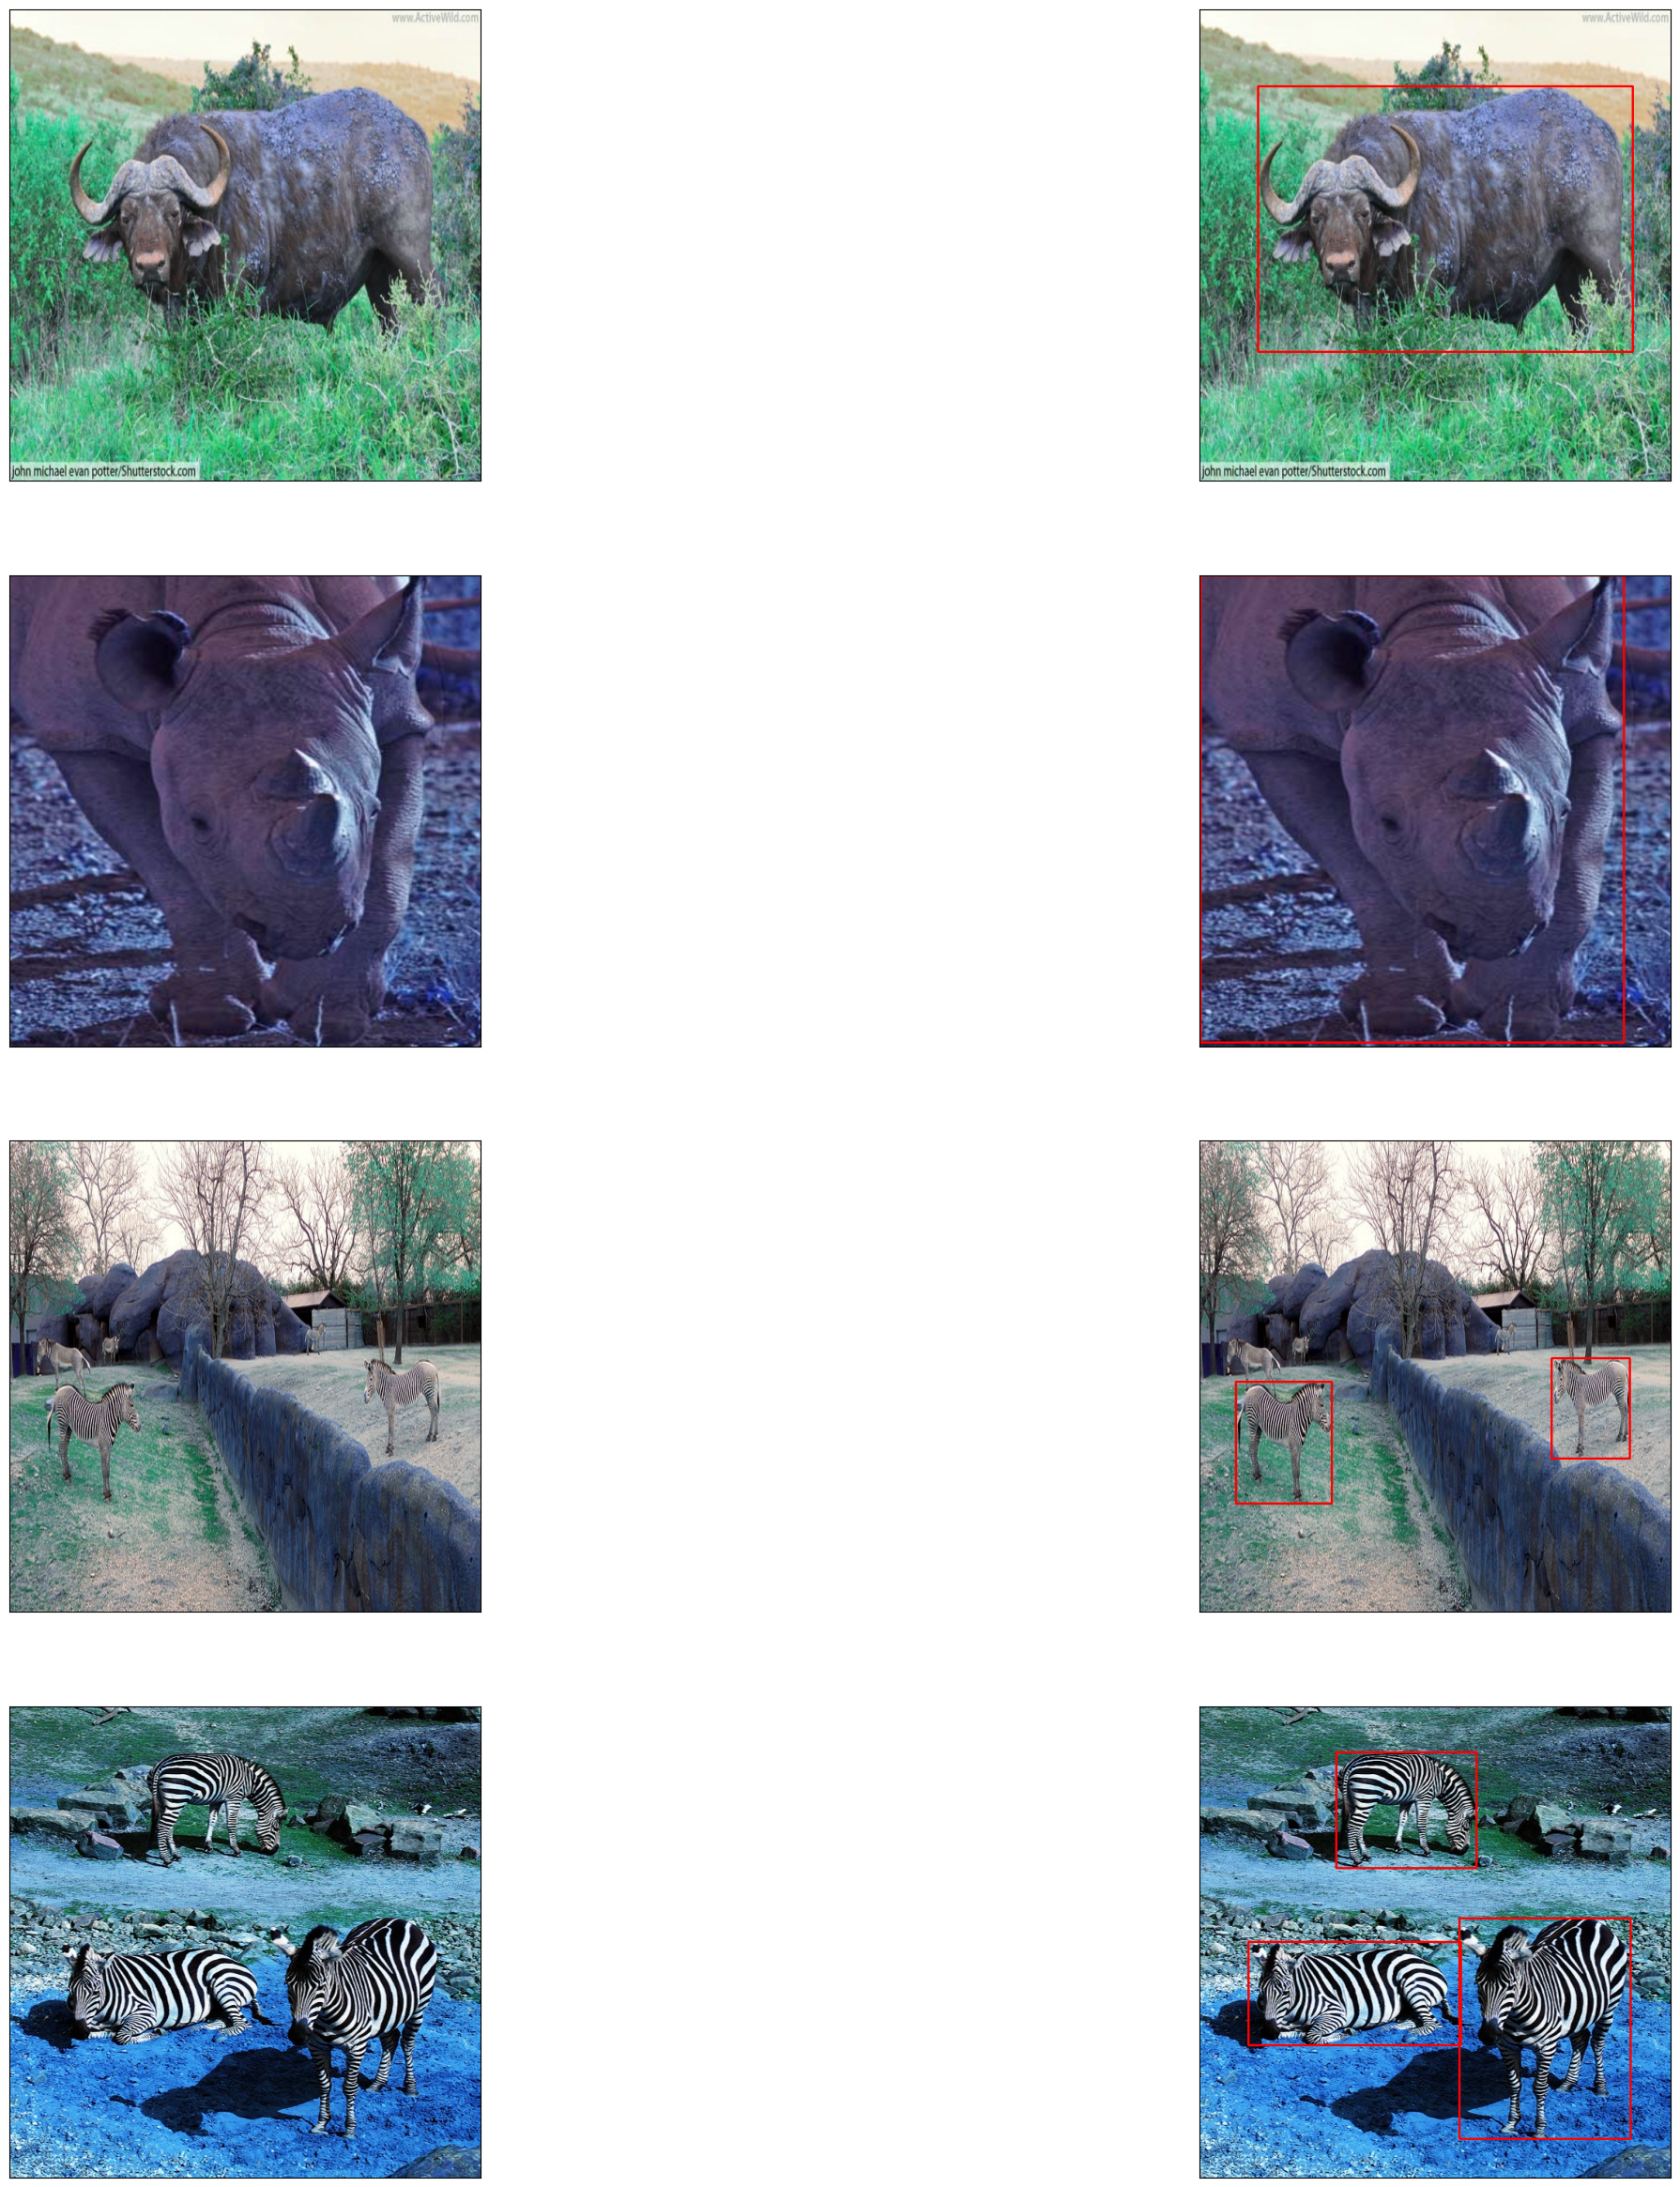

In [29]:
# Drawing bounding box for random images in training data
plt.figure(figsize=(30,30))
for i in range(1,8,2):
    k=random.randint(0, len(os.listdir(imgtrainpath))-1)
    img_path=os.path.join(imgtrainpath, sorted(os.listdir(imgtrainpath))[k])
    label_path=os.path.join(labeltrainpath, sorted(os.listdir(labeltrainpath))[k])
    bbox=get_bbox_from_label(label_path) # extracting bounding box coordinates
    image=cv2.imread(img_path)
    image_copy=copy.deepcopy(image)
    ax=plt.subplot(4, 2, i)
    plt.imshow(image) # displaying image
    plt.xticks([])
    plt.yticks([])
    cv2.drawContours(image_copy, bbox, -1, red, 2) # drawing bounding box on copy of image
    ax=plt.subplot(4, 2, i+1)
    plt.imshow(image_copy) # displaying image with bounding box
    plt.xticks([])
    plt.yticks([])

In [30]:
# Starting with a comment in config file
ln_1='# Train/val/test sets'+newline

# train, val and test path declaration
ln_2='train: ' +"'"+imgtrainpath+"'"+newline
ln_3='val: ' +"'" + imgvalpath+"'"+newline
ln_4='test: ' +"'" + imgtestpath+"'"+newline
ln_5=newline
ln_6='# Classes'+newline

# names of the classes declaration
ln_7='names:'+newline
ln_8='  0: buffalo'+newline
ln_9='  1: elephant'+newline
ln_10='  2: rhino'+newline
ln_11='  3: zebra'

config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8, ln_9, ln_10, ln_11]

In [5]:
# Creating path for config file
config_path=os.path.join(curr_path, 'config.yaml')
config_path

'c:\\Users\\aayud\\OneDrive\\Desktop\\VS Code\\Web Dev\\TSEC Hacks Artemis\\mlserver\\wildlife_detection\\config.yaml'

In [32]:
# Writing config file
with open(config_path, 'w') as f:
    f.writelines(config_lines)

In [6]:
# Using YOLO's pretrained model architecture and weights for training
model=YOLO('yolov8m.yaml').load('./models/yolov8m.pt')

Transferred 475/475 items from pretrained weights


In [ ]:
#  Training the model
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
results=model.train(data=config_path, epochs=50, device = device)
model.save('wildlife_detector.pt')

New https://pypi.org/project/ultralytics/8.3.69 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8m.yaml, data=c:\Users\aayud\OneDrive\Desktop\VS Code\Web Dev\TSEC Hacks Artemis\mlserver\wildlife_detection\config.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train18, exist_ok=False, pretrained=./models/yolov8m.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning C:\Users\aayud\OneDrive\Desktop\VS Code\Web Dev\TSEC Hacks Artemis\mlserver\wildlife_detection\labels\train.cache... 1189 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1189/1189 [00:00<?, ?it/s]
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.2 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\aayud\OneDrive\Desktop\VS Code\Web Dev\TSEC Hacks Artemis\mlserver\wildlife_detection\labels\validation.cache... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]


Plotting labels to runs\detect\train18\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train18
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.14G     0.8923      1.661      1.335         21        640: 100%|██████████| 75/75 [02:48<00:00,  2.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        297        557      0.622      0.461      0.481      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.17G      1.143      1.568      1.544         15        640: 100%|██████████| 75/75 [01:46<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]

                   all        297        557      0.491      0.343      0.326      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.18G      1.223      1.616      1.587         22        640: 100%|██████████| 75/75 [02:20<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]

                   all        297        557      0.457      0.347      0.304      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.15G       1.18      1.498      1.542         19        640: 100%|██████████| 75/75 [02:09<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]

                   all        297        557      0.604      0.596      0.609      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.18G      1.138      1.408       1.52         28        640: 100%|██████████| 75/75 [02:00<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.10s/it]

                   all        297        557      0.553      0.489      0.489      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.07G      1.103      1.331       1.48         19        640: 100%|██████████| 75/75 [01:42<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]

                   all        297        557      0.767      0.585      0.716      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.15G      1.061       1.29      1.456         25        640: 100%|██████████| 75/75 [01:44<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.18s/it]

                   all        297        557      0.743      0.694       0.74      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.16G      1.026      1.188       1.42         18        640: 100%|██████████| 75/75 [02:39<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]

                   all        297        557      0.706       0.62      0.709      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.18G     0.9907      1.145       1.41         17        640: 100%|██████████| 75/75 [01:33<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

                   all        297        557       0.72      0.586      0.685      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.09G     0.9637      1.102      1.372         17        640: 100%|██████████| 75/75 [02:34<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

                   all        297        557      0.828       0.73      0.817      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.15G      0.948      1.044      1.366         20        640: 100%|██████████| 75/75 [01:41<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]

                   all        297        557      0.778      0.633       0.74      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.14G     0.9383      1.028      1.363         11        640: 100%|██████████| 75/75 [02:27<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]

                   all        297        557      0.819      0.761      0.844      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.17G     0.9094      1.025      1.331         19        640: 100%|██████████| 75/75 [01:30<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

                   all        297        557      0.818      0.783       0.85      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       7.2G     0.8914     0.9498      1.323         18        640: 100%|██████████| 75/75 [01:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]

                   all        297        557      0.842      0.788      0.862      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.16G      0.874     0.9757      1.308         16        640: 100%|██████████| 75/75 [02:28<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]

                   all        297        557      0.849      0.767      0.857      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.18G     0.8733     0.9302       1.32         14        640: 100%|██████████| 75/75 [01:46<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

                   all        297        557      0.871      0.784       0.88       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.18G     0.8558     0.9014      1.297         25        640: 100%|██████████| 75/75 [01:53<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]

                   all        297        557      0.887       0.79       0.88      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.19G     0.8439     0.8703      1.284         28        640: 100%|██████████| 75/75 [02:46<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]

                   all        297        557      0.862      0.816      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.17G     0.8217     0.8391      1.275         20        640: 100%|██████████| 75/75 [04:57<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

                   all        297        557      0.891      0.812      0.901      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.14G     0.8253     0.8468      1.271         11        640: 100%|██████████| 75/75 [03:29<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]

                   all        297        557      0.865      0.799      0.894      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.17G     0.8198     0.8221      1.271         11        640: 100%|██████████| 75/75 [03:12<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:27<00:00,  2.71s/it]

                   all        297        557      0.879      0.839      0.905      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.07G     0.7825     0.7943      1.251         20        640: 100%|██████████| 75/75 [03:14<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:31<00:00,  3.11s/it]

                   all        297        557      0.868      0.846      0.899      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.17G     0.7677     0.7832      1.241         18        640: 100%|██████████| 75/75 [04:49<00:00,  3.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:46<00:00,  4.63s/it]

                   all        297        557      0.876      0.838      0.893      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.15G     0.7762     0.7791      1.252         15        640: 100%|██████████| 75/75 [04:28<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

                   all        297        557      0.882      0.859      0.903      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.17G      0.761      0.729      1.231         65        640:  80%|████████  | 60/75 [02:00<00:30,  2.04s/it]

In [ ]:
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the trained model
model = YOLO('wildlife_detector.pt')  # Replace 'best_model.pt' with the path to your trained model

metrics = model.val(data=config_path, device=device)

# Print the evaluation metrics
print(metrics)

# Visualize predictions on a few validation images
def visualize_predictions(model, image_paths):
    for image_path in image_paths:
        results = model(image_path)
        results.show()

# List of validation images to visualize
val_image_paths = [
    'data/val/images/image1.jpg',  # Replace with actual paths to your validation images
    'data/val/images/image2.jpg',
    'data/val/images/image3.jpg'
]

YOLOv8m summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning C:\Users\aayud\OneDrive\Desktop\VS Code\Web Dev\TSEC Hacks Artemis\mlserver\wildlife_detection\labels\validation.cache... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]
